# fastReach Data Exploration

## Loading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, KFold
import pickle

pID = '13'

path = '/Users/lukasgehrke/Documents/publications/2021-fastReach/data/study/eeglab2python/'
data_fname = '/data.csv'
data = pd.read_csv(path+pID+data_fname)

# selected EEG chans
chans_fname = '/chans.csv'
chans = np.array(pd.read_csv(path+pID+chans_fname))

filename = path+pID+'/chans_'+pID+'_eeg.sav'
pickle.dump(chans, open(filename, 'wb'))

data.head()

,sample,epoch_ix,rp_class,Motion,FT9,C3,T7,TP9,CP5,Pz,...,PO4,PO8,P2,CPz,CP4,TP8,C6,C2,FT8,VEOG
0,-0.996,1,1,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.992,1,1,0.000130,2.642541,0.795712,1.094416,0.669853,1.103931,0.062644,...,1.632225,0.916550,3.937309,0.055092,-0.023436,-0.934212,3.726896,-2.954842,1.081888,0.402967
2,-0.988,1,1,0.000138,4.037971,1.400323,0.792254,0.673454,4.860895,-0.141215,...,1.978375,3.601517,5.770657,-0.302124,-1.098618,-3.742458,3.631891,-5.263859,1.569884,-0.448196
3,-0.984,1,1,0.000143,2.612511,1.050192,-0.907860,3.174278,5.182196,0.485991,...,-0.421164,3.754784,3.223236,-0.567856,-0.139374,-5.854919,0.317804,-9.131665,1.034431,-3.180458
4,-0.980,1,1,0.000159,-1.274637,-0.011828,-2.066075,-0.069046,2.945776,-2.638183,...,-1.796372,3.947403,3.094349,-1.999123,1.868982,-4.698679,-3.632471,-12.950356,-0.065014,-5.332201


## Build feature matrix EEG

In [2]:
# import feature computation functions

# EEG features
# 1. windowed means over EEG channels
win_mean_size = 25
win_mean = np.arange(len(data))//win_mean_size

win_mean = data.groupby(win_mean).mean()

df2 = win_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_mean.columns[4:].tolist())
df2.reset_index(inplace=True)
df2.head()


epoch_ix rp_class        FT9                                   \
sample                       -0.948     -0.848     -0.748     -0.648   
0           1.0      1.0  -0.923830  -6.016569  -3.240491  -6.868056   
1           2.0      1.0   1.491419  -0.865089   7.950646   0.362146   
2           3.0      1.0  -2.510929   9.309809  -0.497459   1.495378   
3           4.0      1.0   3.236836  -0.378511   5.038201   2.491134   
4           5.0      1.0 -12.221562 -19.138875 -15.224287 -13.626676   

                                                                      ...  \
sample -0.5479999999999999 -0.44799999999999995     -0.348    -0.248  ...   
0                -6.362406             0.894792   3.576017  2.012898  ...   
1                 3.318065            17.199489  10.738544  2.734218  ...   
2                 2.626250             2.655960  -3.333024  5.834591  ...   
3                 9.633674             5.805531   4.219868  2.284734  ...   
4                -1.589434            14.395535   5.834172  6.391099  ...   

            VEOG                                                       \
sample    -0.948     -0.848     -0.748     -0.648 -0.5479999999999999   
0      -8.069371 -12.605159 -12.842310 -13.442452          -11.238041   
1       3.815844   5.821719  13.082676  13.858578           17.977625   
2       6.292936   9.910996   7.284989  11.068451            9.360864   
3       0.954676   1.767637   6.143521   3.013394            5.174830   
4      -3.977731 -12.465606  -7.856919  -8.637746           -4.177885   

                                                                        \
sample -0.44799999999999995     -0.348     -0.248 -0.14800000000000002   
0                 -1.905311  -8.826726  -5.005743            -4.292648   
1                 26.148424  21.326617  17.472082            12.406159   
2                  6.924257   5.489157  13.331533             8.509867   
3                  4.947458   4.487536   3.255619            -0.631930   
4                  1.021719  -7.507270  -0.184558            -6.621491   

                   
sample     -0.048  
0      -10.067536  
1       26.598519  
2       15.301881  
3       -4.140282  
4       -6.902923  

[5 rows x 402 columns]

# Train & Inspect Models

## EEG

In [3]:
clf = LDA(solver='lsqr', shrinkage='auto')

# win_mean = pd.melt(win_mean, id_vars=['rp_class'], value_vars=win_mean.columns[5:].tolist())
# clf.fit(win_mean.iloc[:,2:].values, win_mean.rp_class)

eeg_dim1 = 2

clf.fit(df2.iloc[:,eeg_dim1:].values, df2.rp_class)
# clf.fit(win_mean.iloc[:,5:].values, win_mean.rp_class)
print(clf.coef_.shape)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf, df2.iloc[:,eeg_dim1:].values, df2.rp_class, cv=kfolds)
print(cv_results)
cv_average = cv_results.mean()
print(cv_average)
st_deviation = cv_results.std()
print(st_deviation)

filename = path+pID+'/model_'+pID+'_eeg.sav'
pickle.dump(clf, open(filename, 'wb'))


(1, 400)
[0.66666667 0.66666667 0.66666667 0.73333333 0.73333333 0.66666667
 0.92857143 0.57142857 0.78571429 0.71428571]
0.7133333333333333
0.09011959803568467


## Motion

In [4]:
clf = LDA()

# df3 = win_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_mean.columns[3])
# df3.reset_index(inplace=True)
# clf.fit(df3.iloc[:,2:].values, df3.rp_class)

# feat = win_mean.iloc[:,2].values
# clf.fit(feat.reshape(-1, 1), win_mean.rp_class)
# clf.fit(data.iloc[:,motion_dim].values.reshape(-1,1), data.rp_class)

mov_data = data.groupby(['epoch_ix']).mean()
clf.fit(mov_data.Motion.values.reshape(-1,1), mov_data.rp_class)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

# cv_results = cross_val_score(clf, feat.reshape(-1, 1), win_mean.rp_class, cv=kfolds)
cv_results = cross_val_score(clf, mov_data.Motion.values.reshape(-1,1), mov_data.rp_class, cv=kfolds)
cv_average = cv_results.mean()
print(cv_average)
st_deviation = cv_results.std()

filename = path+pID+'/model_'+pID+'_motion.sav'
pickle.dump(clf, open(filename, 'wb'))

1.0


# Plots

## Features

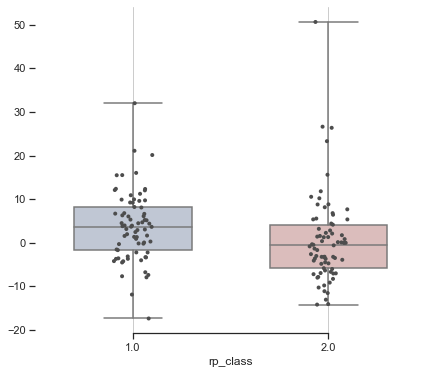

In [5]:
# g = sns.lmplot(x='Motion',y='Motion', data=data, hue='rp_class', fit_reg=False)
# g.set_axis_labels('{} muscle1'.format(feature), '{} muscle2'.format(feature))

data_short = data.groupby(['epoch_ix']).mean()

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
group_var = "rp_class"
val_var = "Pz"
sns.boxplot(x=group_var, y=val_var, data=data_short,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x=group_var, y=val_var, data=data_short,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)


## Linear Discriminant(s) Plot

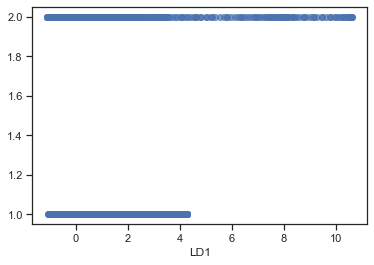

In [6]:
clf = LDA(n_components=1)
# data.loc[0,:]=np.zeros(data.shape[1])
# data_short = data.grouby(['epoch_ix']).mean()

transf_lda = clf.fit_transform(data.iloc[:,3].values.reshape(-1,1), data.rp_class)

# print(transf_lda)

plt.xlabel('LD1')
# plt.ylabel('LD2')
plt.scatter(
    x=transf_lda[:,0],
    y=data.rp_class,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

# import matplotlib.pyplot as plt
# for label,marker,color in zip(range(1,3),('o','^'),('red','blue')):
#     plt.scatter(x=transf_lda[:,0][data.rp_class == label],
#            y=[data.rp_class == label], marker=marker,
#            color=color, alpha=0.7, label='class {}'.format(label))

# #plt.xlabel('vector 1')
# #plt.ylabel('vector 2')

# plt.legend(loc='lower right')
# plt.title('dimensionality reduction for data set')

# plt.show()

## ERP Readiness Potential Plot

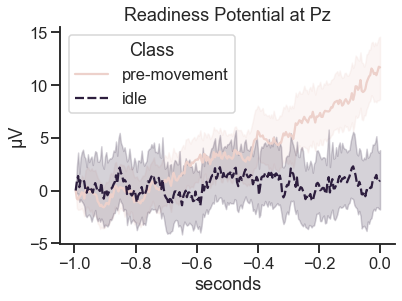

In [6]:
sns.set_theme(style="ticks")
sns.set_context("talk")

electrode = "Pz"

# Plot the responses for different events and regions
g = sns.lineplot(x="sample", y=electrode,
             hue="rp_class", style="rp_class",
             data=data)
sns.despine()
g.set(xlabel='seconds', ylabel='\u03bcV', title='Readiness Potential at '+electrode)

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

## Trial Progression

In [10]:
data_fname = '/data_for_plot_Cz.csv'
data = pd.read_csv(path+pID+data_fname)

sns.set(rc={'figure.figsize':(16,4)})

sns.set_theme(style="ticks")
sns.set_context("talk")

# Plot the responses for different events and regions
g = sns.lineplot(x="sample", y=data.columns[3], 
    hue="type", style="type", data=data)
sns.despine()

g.set(xlabel='seconds', ylabel='a.u.', title='Trial Progression')

xcoords = [-10, -1, 0]
for xc in xcoords:
    plt.axvline(x=xc, color='k', linestyle='--', alpha=.6)

electrode = "Pz"
# legend
leg = g.legend_
new_title = 'Data'
leg.set_title(new_title)
# replace labels
new_labels = ['Electrode '+electrode, 'Hand Velocity']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

plt.savefig("figure.pdf") # save as png

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lukasgehrke/Documents/publications/2021-fastReach/data/study/eeglab2python/5/data_for_plot_Cz.csv'

In [86]:
data.columns[3]

'MotionFT10'

In [41]:

# this looks all to be correct

path = '/Users/lukasgehrke/Documents/publications/2021-fastReach/data/study/eeglab2python/'
data_fname = '/data_long_test.csv'
data = pd.read_csv(path+pID+data_fname)

data.head()

all_data = np.array(data)
all_data.shape

window_size = 250
frame_rate = 25

# feat_data = all_data - np.expand_dims(all_data[:,0],1)
feat_data = np.reshape(all_data, (40, int(window_size/frame_rate), frame_rate))
feats = np.mean(feat_data, axis = 2).flatten().reshape(1,-1)

feats
                    

array([[ -0.23453285,  12.73908682,  -6.66416564,  -4.11358385,
        -15.40597038, -18.55180668, -12.63854605,  -5.9045876 ,
        -10.40469896,  -4.07746607,  27.92047184,  38.01394417,
         21.10924232,  25.76171814,  10.66613782,   7.76738026,
          9.51026133,  14.53960989,   8.55343914,  11.1479215 ,
         95.45102295, 106.63333801,  95.26371216,  95.90168304,
         88.11197693,  79.84805756,  80.55494049,  81.71627075,
         84.00977112,  91.96941345,  56.75897156,  63.78780258,
         46.93867676,  46.79913452,  38.9072905 ,  38.98198692,
         41.72234726,  50.49565643,  40.4611525 ,  35.44686432,
         65.51058197,  74.71915192,  59.72117447,  62.76731308,
         49.90783859,  51.36529228,  54.00534714,  61.41110519,
         56.90709885,  53.52354904,  65.35614746,  77.315065  ,
         57.98446457,  59.1300444 ,  50.85898788,  52.14499344,
         55.85556152,  64.11650253,  56.09855469,  53.08280685,
        115.46301147, 126.97088684, 107.

In [10]:
#!/usr/bin/env python
"""
ReceiveAndPlot example for LSL

This example shows data from all found outlets in realtime.
It illustrates the following use cases:
- efficiently pulling data, re-using buffers
- automatically discarding older samples
- online postprocessing
"""

import numpy as np
import math
import pylsl
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtWidgets
from typing import List

# Basic parameters for the plotting window
plot_duration = 5  # how many seconds of data to show
update_interval = 60  # ms between screen updates
pull_interval = 500  # ms between each pull operation


class Inlet:
    """Base class to represent a plottable inlet"""
    def __init__(self, info: pylsl.StreamInfo):
        # create an inlet and connect it to the outlet we found earlier.
        # max_buflen is set so data older the plot_duration is discarded
        # automatically and we only pull data new enough to show it

        # Also, perform online clock synchronization so all streams are in the
        # same time domain as the local lsl_clock()
        # (see https://labstreaminglayer.readthedocs.io/projects/liblsl/ref/enums.html#_CPPv414proc_clocksync)
        # and dejitter timestamps
        self.inlet = pylsl.StreamInlet(info, max_buflen=plot_duration,
                                       processing_flags=pylsl.proc_clocksync | pylsl.proc_dejitter)
        # store the name and channel count
        self.name = info.name()
        self.channel_count = info.channel_count()

    def pull_and_plot(self, plot_time: float, plt: pg.PlotItem):
        """Pull data from the inlet and add it to the plot.
        :param plot_time: lowest timestamp that's still visible in the plot
        :param plt: the plot the data should be shown on
        """
        # We don't know what to do with a generic inlet, so we skip it.
        pass


class DataInlet(Inlet):
    """A DataInlet represents an inlet with continuous, multi-channel data that
    should be plotted as multiple lines."""
    dtypes = [[], np.float32, np.float64, None, np.int32, np.int16, np.int8, np.int64]

    def __init__(self, info: pylsl.StreamInfo, plt: pg.PlotItem):
        super().__init__(info)
        # calculate the size for our buffer, i.e. two times the displayed data
        bufsize = (2 * math.ceil(info.nominal_srate() * plot_duration), info.channel_count())
        self.buffer = np.empty(bufsize, dtype=self.dtypes[info.channel_format()])
        empty = np.array([])
        # create one curve object for each channel/line that will handle displaying the data
        self.curves = [pg.PlotCurveItem(x=empty, y=empty, autoDownsample=True) for _ in range(self.channel_count)]
        for curve in self.curves:
            plt.addItem(curve)

    def pull_and_plot(self, plot_time, plt):
        # pull the data
        _, ts = self.inlet.pull_chunk(timeout=0.0,
                                      max_samples=self.buffer.shape[0],
                                      dest_obj=self.buffer)
        # ts will be empty if no samples were pulled, a list of timestamps otherwise
        if ts:
            ts = np.asarray(ts)
            y = self.buffer[0:ts.size, :]
            this_x = None
            old_offset = 0
            new_offset = 0
            for ch_ix in range(self.channel_count):
                # we don't pull an entire screen's worth of data, so we have to
                # trim the old data and append the new data to it
                old_x, old_y = self.curves[ch_ix].getData()
                # the timestamps are identical for all channels, so we need to do
                # this calculation only once
                if ch_ix == 0:
                    # find the index of the first sample that's still visible,
                    # i.e. newer than the left border of the plot
                    old_offset = old_x.searchsorted(plot_time)
                    # same for the new data, in case we pulled more data than
                    # can be shown at once
                    new_offset = ts.searchsorted(plot_time)
                    # append new timestamps to the trimmed old timestamps
                    this_x = np.hstack((old_x[old_offset:], ts[new_offset:]))
                # append new data to the trimmed old data
                this_y = np.hstack((old_y[old_offset:], y[new_offset:, ch_ix] - ch_ix))
                # replace the old data
                self.curves[ch_ix].setData(this_x, this_y)


class MarkerInlet(Inlet):
    """A MarkerInlet shows events that happen sporadically as vertical lines"""
    def __init__(self, info: pylsl.StreamInfo):
        super().__init__(info)

    def pull_and_plot(self, plot_time, plt):
        # TODO: purge old markers
        strings, timestamps = self.inlet.pull_chunk(0)
        print(strings)
        if timestamps:
            for string, ts in zip(strings, timestamps):
                plt.addItem(pg.InfiniteLine(ts, angle=90, movable=False, label=string[0]))


def main():
    # firstly resolve all streams that could be shown
    inlets: List[Inlet] = []
    print("looking for streams")
    streams = pylsl.resolve_streams()

    # Create the pyqtgraph window
    pw = pg.plot(title='LSL Plot')
    plt = pw.getPlotItem()
    plt.enableAutoRange(x=False, y=True)

    # iterate over found streams, creating specialized inlet objects that will
    # handle plotting the data
    for info in streams:
        if info.type() == 'Markers':
            if info.nominal_srate() != pylsl.IRREGULAR_RATE \
                    or info.channel_format() != pylsl.cf_string:
                print('Invalid marker stream ' + info.name())
            print('Adding marker inlet: ' + info.name())
            inlets.append(MarkerInlet(info))
        elif info.nominal_srate() != pylsl.IRREGULAR_RATE \
                and info.channel_format() != pylsl.cf_string:
            print('Adding data inlet: ' + info.name())
            inlets.append(DataInlet(info, plt))
        else:
            print('Don\'t know what to do with stream ' + info.name())

    def scroll():
        """Move the view so the data appears to scroll"""
        # We show data only up to a timepoint shortly before the current time
        # so new data doesn't suddenly appear in the middle of the plot
        fudge_factor = pull_interval * .002
        plot_time = pylsl.local_clock()
        pw.setXRange(plot_time - plot_duration + fudge_factor, plot_time - fudge_factor)

    def update():
        # Read data from the inlet. Use a timeout of 0.0 so we don't block GUI interaction.
        mintime = pylsl.local_clock() - plot_duration
        # call pull_and_plot for each inlet.
        # Special handling of inlet types (markers, continuous data) is done in
        # the different inlet classes.
        for inlet in inlets:
            inlet.pull_and_plot(mintime, plt)

    # create a timer that will move the view every update_interval ms
    update_timer = QtCore.QTimer()
    update_timer.timeout.connect(scroll)
    update_timer.start(update_interval)

    # create a timer that will pull and add new data occasionally
    pull_timer = QtCore.QTimer()
    pull_timer.timeout.connect(update)
    pull_timer.start(pull_interval)

    import sys

    # Start Qt event loop unless running in interactive mode or using pyside.
    if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
        QtWidgets.QApplication.instance().exec_()


if __name__ == '__main__':
    main()

looking for streams
Adding data inlet: BrainVision RDA
